# Usage

The `torch_mist` package can be used for estimating mutual information using the pre-defined mutual information estimators included in the library or for developing, analyzing and evaluating new estimation strategies.
Here we show different usage that range from basic (simple to use, limited settings) to advanced (maximum flexibility, more complex to use).

To showcase the package, we first generate samples $x,y\sim p(x,y)$ from a bivariate normal distribution with known true mutual information.

In [1]:
import torch
from torch.distributions import MultivariateNormal, Normal

# Definition of the distribution
p_xy = MultivariateNormal(
    loc=torch.tensor([0., 0.]),
    covariance_matrix=torch.tensor([
        [1.0, 0.9], 
        [0.9, 1.0]
    ])
)
p_x = p_y = Normal(0, 1)

# I(x;y) = H(x)+H(y)-H(x,y)
true_mi = (
        p_x.entropy() + p_y.entropy() - p_xy.entropy()
).sum().item()
print(f"True Mutual Information: {true_mi} nats")

# Generate 100000 samples
samples = p_xy.sample([100000])
x = samples[:,0]
y = samples[:,1]

True Mutual Information: 0.8303654193878174 nats


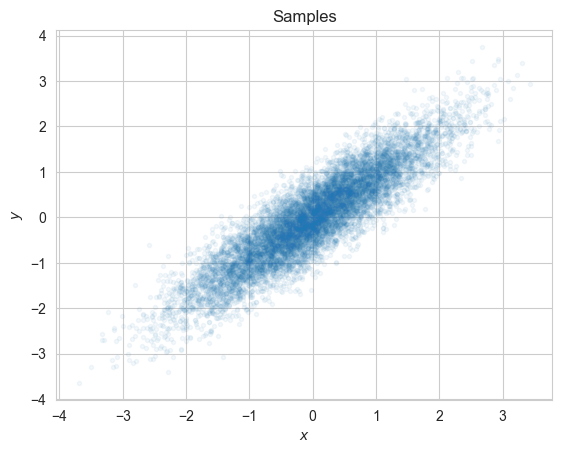

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Plot them
plt.scatter(
    x[::10], y[::10],
    marker='.',
    alpha=0.05
)
plt.title("Samples")
plt.xlabel('$x$')
plt.ylabel('$y$');

## Basic Usage
We first showcase the simplest use-case, in which we can use `estimate_mi` to estimate mutual information given paired samples `x` and `y`. This function takes care of instantiating the estimator, training it and evaluating the mutual information.

In [3]:
from torch_mist import estimate_mi

mi_estimate, estimator, train_log = estimate_mi(
    estimator_name='js',            # The mutual information estimator to use (here we use the Deep InfoMax JS estimator)
    hidden_dims=[32, 32],           # The hidden layers for the neural architectures (Estimator specific)  
    neg_samples=16,                 # The number of negative samples used to estimate the log partition function (Estimator specific, Default: 1)
    x=x,                            # The values of x
    y=y,                            # The values of y
    batch_size=128,                 # The batch size used for training (Default: 64)
    max_epochs=5,                   # Number of maximum training epochs (Default: 10)
    valid_percentage=0.1,           # The percentage of data to use for validation (Default: 0.1)
    evaluation_batch_size=256,      # The batch size used for evaluation (Default: batch_size)
    device='cpu',                   # The training device (Default: 'cpu')
    return_estimator=True,          # Flag to return the trained estimator (Default: False)
    return_log=True,                # Flag to return the training log (Default: False)
)

print(f"Estimated Mutual Information: {mi_estimate} nats")
print(f"True Mutual Information: {true_mi} nats")

Instantiating the js estimator
JS(
  (ratio_estimator): JointCritic(
    (joint_net): DenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=2, out_features=32, bias=True)
        (1): Linear(in_features=32, out_features=32, bias=True)
        (2): Linear(in_features=32, out_features=1, bias=True)
      )
      (f): ReLU(inplace=True)
    )
  )
  (baseline): ConstantBaseline()
  (neg_samples): 16
)
Training the estimator


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating the value of Mutual Information
Estimated Mutual Information: 0.8213312836254344 nats
True Mutual Information: 0.8303654193878174 nats


The training curves are easily accessible from the `train_log`

(1.0, 5.2)

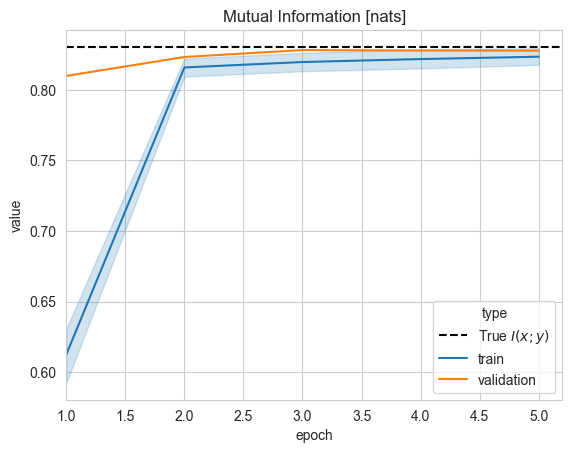

In [4]:
# We can plot the estimated values by epoch
plt.title("Mutual Information [nats]")
plt.axhline(y=true_mi, ls='--', color='k', label='True $I(x;y)$')
sns.lineplot(train_log, x='epoch', y='value', hue='type')
plt.xlim(1)

## Advanced Usage

Instead of using the `estimate_mi` function directly, it is possible to manually instantiate the estimators and specify additional details for the training and evaluation procedures, as described in the following sections.
 
### Estimators
We start by defining a simple mutual information estimator based on Deep-InfoMax (JS) with joint critic architecture.

In [5]:
from torch_mist.estimators import JS
from torch_mist.critic import JointCritic
from torch import nn

x_dim = y_dim = 1

# First we define a critic network that maps pairs of samples to a scalar.
# The JointCritic module takes care of concatenating the pairs of x and y, adapting the shapes when necessary
critic = JointCritic(
    joint_net=nn.Sequential(
        nn.Linear(x_dim + y_dim, 32),
        nn.ReLU(True),
        nn.Linear(32, 32),
        nn.ReLU(True),
        nn.Linear(32, 1),
    )
)

# We also specify the number of Monte Carlo samples to use for the estimation of the partition function
neg_samples = 16

# Then we pass it to the Jensen-Shannon estimator
estimator = JS(
    critic=critic,
    neg_samples=neg_samples
)

print(estimator)

JS(
  (ratio_estimator): JointCritic(
    (joint_net): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (baseline): ConstantBaseline()
  (neg_samples): 16
)


Each estimator `EstimatorName(...)` is equipped with a factory function `estimator_name(...)` for easy instantiation with limited configuration.

In [6]:
from torch_mist.estimators import js # The factory function for JS

estimator_2 = js(
    x_dim=x_dim,
    y_dim=y_dim,
    hidden_dims=[32, 32],
    neg_samples=neg_samples,
    critic_type='joint',
)

print(estimator)

JS(
  (ratio_estimator): JointCritic(
    (joint_net): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (baseline): ConstantBaseline()
  (neg_samples): 16
)


Note that the two estimators defined above are equivalent.

### Training
Instead of using the paired `x` and `y` directly, we can define the dataloaders, optimizer and train the estimator with a simple training loop.

In [7]:
from tqdm.autonotebook import tqdm
from torch.optim import AdamW
from torch_mist.utils.data import SampleDataset
from torch.utils.data import DataLoader
import pandas as pd

# We use a simple wrapper to make a torch.utils.data.Dataset object using the pairs of x and y
dataset = SampleDataset({'x': x, 'y': y})

# Then we make a DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True
)

# Use the AdamW optimizer with a learning rate of 5e-4
opt = AdamW(estimator.parameters(), lr=5e-4)

# Train for 5 epochs
n_epochs = 5

# Log to visualize the training progress
log = []

# For each epoch
for epoch in range(n_epochs):
    # Sample a batch of pairs
    for data in tqdm(dataloader):
        x, y = data['x'], data['y']
        
        # Compute the loss
        loss = estimator.loss(x, y)
        
        # And the corresponding estimation of Mutual Information (optional, for logging purposes)
        mi = estimator(x, y)

        # Update the parameters of the estimator
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Log the loss
        log.append({
            'iteration': len(log),
            'loss': loss.item(),
            'value': mi.item()
        })
        
pd_log = pd.DataFrame(log)

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

We can plot loss and estimated mutual information over time

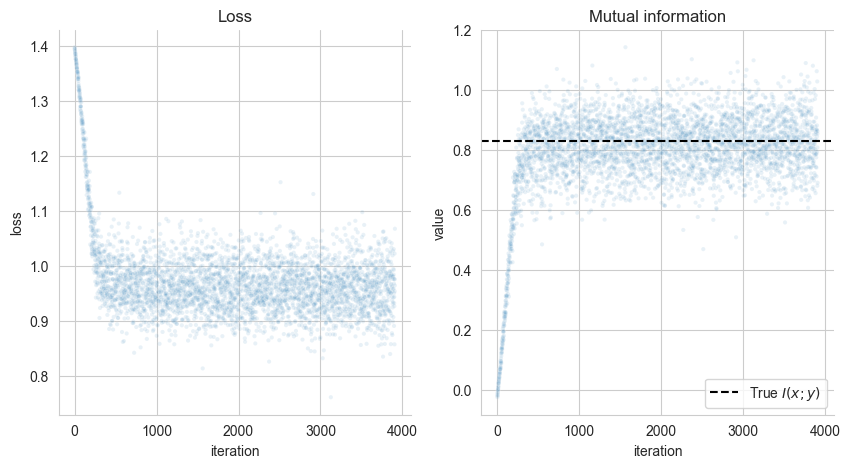

In [8]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.axhline(y=true_mi, ls='--', color='k', label='True $I(x;y)$')
sns.scatterplot(pd_log, x='iteration', y='loss', ax=ax[0], marker='.', ls='', alpha=0.1)
sns.scatterplot(pd_log, x='iteration', y='value', ax=ax[1], marker='.', ls='', alpha=0.1)

ax[0].set_title('Loss')
ax[1].set_title('Mutual information')
ax[1].legend()

sns.despine()

Alternatively, we provide a functionality to train a mutual information estimator given either `DataLoader` objects or paired `x` and `y` tensors and a `batch_size` value. By default, in the latter case, this function creates a validation set of `valid_percentage=0.1` that is used for early stopping.
The two procedures reported below are equivalent.

In [9]:
from torch_mist.train import train_mi_estimator

train_using_dataloader = True

if train_using_dataloader:
    train_log = train_mi_estimator(
        estimator=estimator_2,
        max_epochs=5,
        train_loader=dataloader,
        optimizer_class=AdamW,
        return_log=True
    )
else:
    train_log = train_mi_estimator(
        estimator=estimator_2,
        max_epochs=5,
        x=x,
        y=y,
        valid_percentage=0.0,   # Do not use a validation set 
        optimizer_class=AdamW,
        return_log=True
    )

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

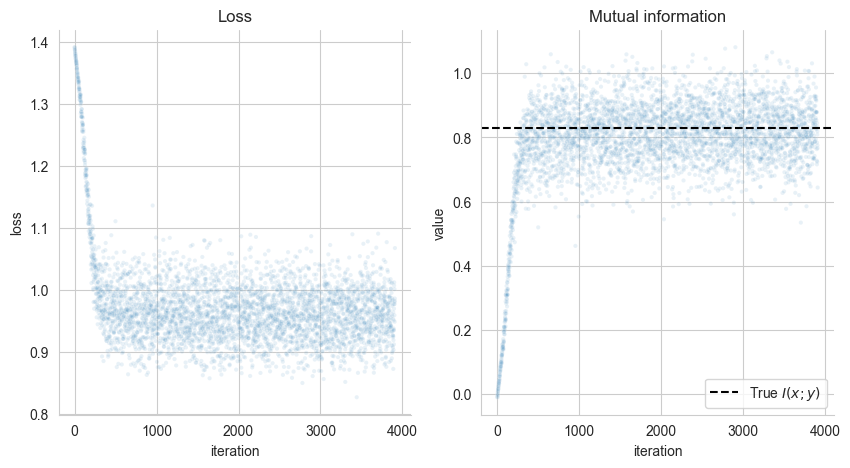

In [10]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.axhline(y=true_mi, ls='--', color='k', label='True $I(x;y)$')
sns.scatterplot(train_log, x='iteration', y='loss', ax=ax[0], marker='.', ls='', alpha=0.1)
sns.scatterplot(train_log, x='iteration', y='value', ax=ax[1], marker='.', ls='', alpha=0.1)

ax[0].set_title('Loss')
ax[1].set_title('Mutual information')
ax[1].legend()

sns.despine()

### Evaluation
We can now evaluate the estimator on the entire dataset

In [11]:
import numpy as np

mi_estimates = []
for data in tqdm(dataloader):
    mi_estimates.append(estimator(data['x'], data['y']).item())

mi_estimate = np.mean(mi_estimates)
print(f"Estimated Mutual Information: {mi_estimate} nats")
print(f"True Mutual Information: {true_mi} nats")

  0%|          | 0/782 [00:00<?, ?it/s]

Estimated Mutual Information: 0.8266522390458285 nats
True Mutual Information: 0.8303654193878174 nats


Or we can use the provided `evaluate_mi` utility function

In [12]:
from torch_mist.utils import evaluate_mi

mi_estimate = evaluate_mi(
    estimator_2,
    dataloader=dataloader
)

print(f"Estimated Mutual Information: {mi_estimate} nats")
print(f"True Mutual Information: {true_mi} nats")

Estimated Mutual Information: 0.8214710391390964 nats
True Mutual Information: 0.8303654193878174 nats


Similarly to `train_mi_estimator`, `evaluate_mi` function supports either `DataLoaders` or paired `x` and `y`.

In [13]:
mi_estimate = evaluate_mi(
    estimator_2,
    x=x,
    y=y,
    batch_size=128
)

print(f"Estimated Mutual Information: {mi_estimate} nats")
print(f"True Mutual Information: {true_mi} nats")

Estimated Mutual Information: 0.6690061092376709 nats
True Mutual Information: 0.8303654193878174 nats
